In [1]:
!pip install osmnx geopandas matplotlib folium


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.1 MB/s eta 0:00:00


In [2]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from geopandas.tools import sjoin
import folium

In [3]:
# Configuration
city_name = "Ciudad de México, Mexico"
poi_type = 'restaurant'


In [4]:
# Download POI and street network data
gdf_poi = ox.geometries_from_place(city_name, tags={'amenity': poi_type})
gdf_streets = ox.graph_from_place(city_name, network_type='drive')
gdf_streets = ox.graph_to_gdfs(gdf_streets, nodes=False, edges=True)

print("POI and street network data downloaded.")



<ipython-input-4-18803b1a8798>:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_poi = ox.geometries_from_place(city_name, tags={'amenity': poi_type})


POI and street network data downloaded.


In [5]:
# Ensure CRS alignment
gdf_poi = gdf_poi.set_crs(epsg=4326)
gdf_streets = gdf_streets.set_crs(epsg=4326)



In [6]:
# Filter relevant columns
gdf_poi = gdf_poi[['name', 'geometry']]

# Display POI data
print(gdf_poi.head())


                                   name                    geometry
element_type osmid                                                 
node         293208350             Toks  POINT (-99.17230 19.34531)
             318084624  Sanborns Loreto  POINT (-99.19286 19.33875)
             319147480         Sanborns  POINT (-99.18802 19.34704)
             326552536             Toks  POINT (-99.17929 19.37407)
             331418533      La Estación  POINT (-99.19095 19.38852)


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

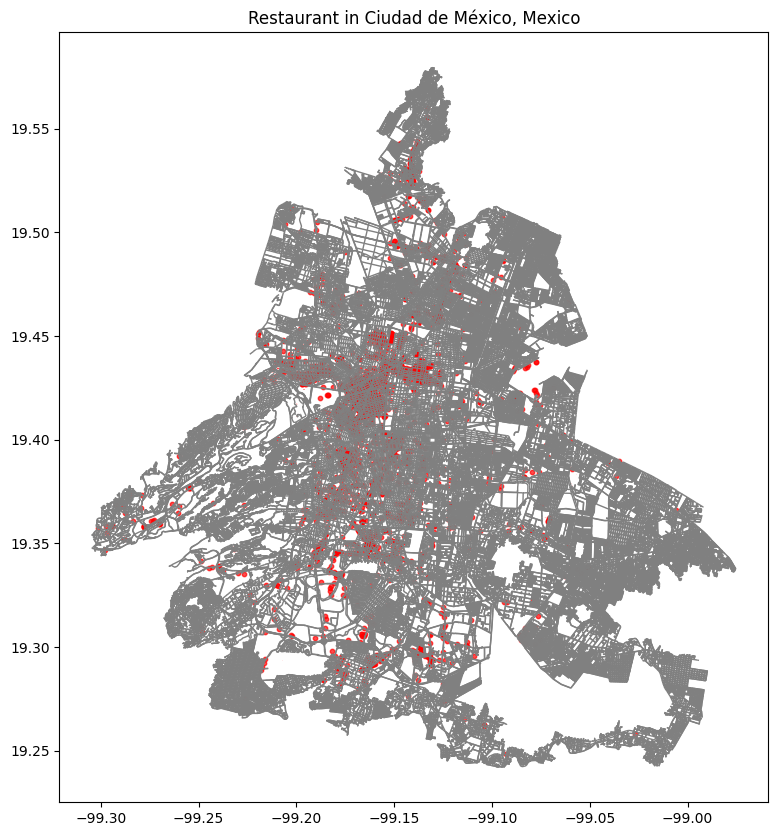

In [7]:
# Plot POI and street network
fig, ax = plt.subplots(figsize=(10, 10))
gdf_streets.plot(ax=ax, linewidth=1, edgecolor='gray')
gdf_poi.plot(ax=ax, color='red', markersize=10, alpha=0.7)
plt.title(f'{poi_type.capitalize()} in {city_name}')
plt.show()


In [8]:
# Create grid for density analysis
xmin, ymin, xmax, ymax = gdf_streets.total_bounds
cell_size = 0.01
grid_cells = [Polygon([(x, y), (x+cell_size, y), (x+cell_size, y+cell_size), (x, y+cell_size)])
              for x in np.arange(xmin, xmax, cell_size)
              for y in np.arange(ymin, ymax, cell_size)]
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf_streets.crs)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Join POI with grid
poi_density = sjoin(gdf_poi, grid, how='left', op='within')
poi_density = poi_density.groupby('index_right').size().reset_index(name='poi_count')
grid.loc[poi_density['index_right'], 'poi_count'] = poi_density['poi_count']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


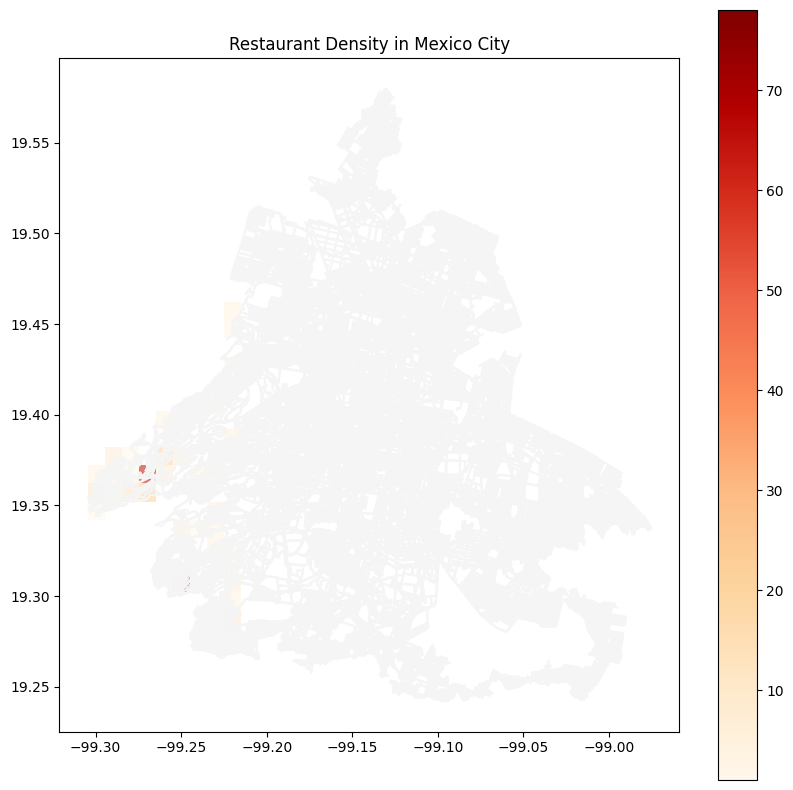

In [10]:
# Plot density map
fig, ax = plt.subplots(figsize=(10, 10))
gdf_streets.plot(ax=ax, color='whitesmoke', edgecolor='black')
grid.plot(column='poi_count', ax=ax, cmap='OrRd', legend=True, alpha=0.6)
plt.title('Restaurant Density in Mexico City')
plt.show()

In [11]:
# Create interactive map
m = folium.Map(location=[gdf_streets.geometry.centroid.y.mean(), gdf_streets.geometry.centroid.x.mean()], zoom_start=12)
for _, row in gdf_poi.iterrows():
    if isinstance(row.geometry, Point):
        folium.Marker([row.geometry.y, row.geometry.x], popup=row['name']).add_to(m)
for _, row in grid.iterrows():
    if 'poi_count' in row and row['poi_count'] > 0:
        folium.CircleMarker(
            location=[row.geometry.centroid.y, row.geometry.centroid.x],
            radius=5,
            popup=f"Density: {row['poi_count']}",
            color='crimson',
            fill=True,
            fill_color='crimson'
        ).add_to(m)
m.save('poi_map.html')
print("Interactive map saved as 'poi_map.html'.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-11-e35d4e7fbee6>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf_streets.geometry.centroid.y.mean(), gdf_streets.geometry.centroid.x.mean()], zoom_start=12)


Interactive map saved as 'poi_map.html'.
